<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>

# STAT542: Statistical Learning

## Final Project ##

* Yu-Ching Liao <ycliao3@illinois.edu>

# Basic Import

In [34]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, NMF, KNNWithMeans
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt

# Reading Data

In [38]:
# Load the data
csv_data = pd.read_csv("Training_set.csv")
display(csv_data.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,NaN,3.0,NaN,3.0,NaN,3.0,5.0,NaN,3.0,4.0,NaN,5.0,5.0,3.0,NaN
1,4.0,NaN,5.0,5.0,2.0,NaN,1.0,NaN,4.0,NaN,NaN,5.0,NaN,5.0,3.0
2,3.0,3.0,NaN,NaN,3.0,3.0,NaN,NaN,1.0,3.0,NaN,4.0,3.0,NaN,3.0
3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,3.0,NaN,NaN,2.0,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,3.0,4.0,NaN,NaN,2.0,NaN


μ: 3.420253164556962
σ: 0.9914035245882147


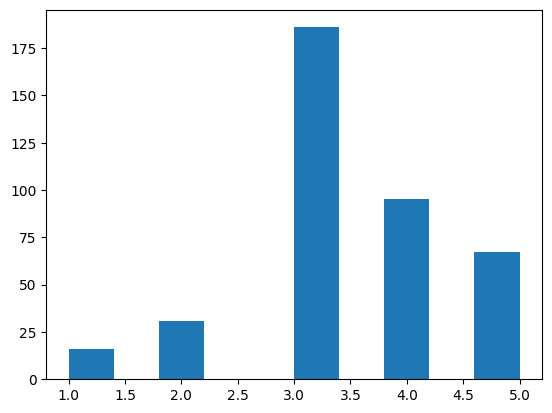

In [44]:
l = []
for i in csv_data.index:
    #print(csv_data.loc[i])
    for j in csv_data.columns:
        #print(csv_data.loc[i][j])
        if not pd.isna(csv_data.loc[i][j]): 
            l.append(csv_data.loc[i][j])
print("μ:", np.mean(l))
print("σ:", np.std(l))

plt.hist(l, bins=10)
plt.show()

# Algorithm

## Singular Value Decomposition (SVD)

In [4]:
# Transform the data into a list of tuples (user_id, video_id, rating)
data = [
    (user_id, video_id, rating)
    for user_id, row in csv_data.iterrows()
    for video_id, rating in enumerate(row, start=1)
    if not pd.isna(rating)
]

# Define the reader to specify the rating_scale
reader = Reader(rating_scale=(1, 5))

# Create the dataset
dataset = Dataset.load_from_df(pd.DataFrame(data, columns=["user_id", "video_id", "rating"]), reader)

# Train the SVD algorithm
svd = SVD()
cross_validate(svd, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the SVD algorithm on the full dataset
trainset = dataset.build_full_trainset()
svd.fit(trainset)

# Fill the missing values in the dataset
filled_data = csv_data.copy()
for user_id, row in csv_data.iterrows():
    for video_id, rating in enumerate(row, start=1):
        if pd.isna(rating):
            prediction = svd.predict(user_id, video_id)
            filled_data.at[user_id, f'V{video_id}'] = prediction.est

print("Filled dataset:")
display(filled_data)

# Function to recommend videos
def recommend_videos(user_id, n_recommendations=5):
    video_ids = set(range(1, 16))  # Assuming 15 videos
    rated_videos = {entry[1] for entry in data if entry[0] == user_id}
    not_rated_videos = video_ids - rated_videos

    # Predict the ratings for the not-rated videos
    predictions = [(video_id, svd.predict(user_id, video_id).est) for video_id in not_rated_videos]

    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]

# Get recommendations for all users
user_ids = csv_data.index.unique().tolist()
all_recommendations = [recommend_videos(user_id) for user_id in user_ids]

# Create a DataFrame with recommendations
recommendations_df = pd.DataFrame(all_recommendations, columns=[f'Rec_{i+1}' for i in range(5)], index=user_ids)
recommendations_df.index.name = 'user_id'

print("\nRecommendations for all users:")
display(recommendations_df)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1231  0.9306  1.2408  1.0895  1.0247  1.0818  0.1031  
MAE (testset)     0.9175  0.7355  1.0437  0.8453  0.8510  0.8786  0.1011  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Filled dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
1,3.000000,2.888926,3.042131,3.000000,3.552513,3.000000,3.000000,2.726607,3.292991,3.000000,3.000000,3.356977,4.000000,3.232373,3.000000
2,3.737880,3.000000,3.000000,3.234729,3.749603,3.135889,3.000000,3.000000,3.309087,3.072848,3.000000,3.505800,5.000000,3.481822,3.000000
3,3.675570,2.856151,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.068235,2.870438,2.867195,4.000000,3.000000,3.000000,2.838782
4,4.000000,4.000000,3.157011,3.251492,3.000000,3.095121,3.254084,3.000000,3.207379,2.000000,2.974542,4.000000,3.884618,4.000000,3.050815
5,5.000000,3.953323,5.000000,5.000000,4.419184,3.951084,5.000000,3.893589,5.000000,3.825782,3.790466,5.000000,4.503836,4.165090,5.000000
6,1.000000,2.714328,4.000000,2.000000,3.423550,2.827455,4.000000,2.730244,4.000000,2.000000,2.647344,3.000000,3.316094,3.140981,2.917050
7,3.508746,3.266230,3.000000,4.000000,3.327419,3.000000,3.412400,3.021325,3.000000,2.840090,1.000000,5.000000,3.330149,3.343608,3.000000
8,2.000000,2.341465,2.476793,2.564321,4.000000,2.576247,2.738974,2.000000,1.000000,2.000000,2.322447,3.000000,1.000000,2.866645,2.000000
9,3.000000,3.047287,3.000000,3.307435,3.588717,5.000000,3.219800,3.000000,3.000000,3.143364,3.000000,3.616362,3.000000,4.000000,3.000000
10,4.112467,4.000000,3.694481,5.000000,4.218742,3.756286,3.743082,3.743050,5.000000,3.564953,3.750163,5.000000,3.945851,4.000000,5.000000



Recommendations for all users:


,Rec_1,Rec_2,Rec_3,Rec_4,Rec_5
user_id,,,,,
1,"Recommended Video: V5, Score: 3.55251","Recommended Video: V12, Score: 3.35698","Recommended Video: V9, Score: 3.29299","Recommended Video: V14, Score: 3.23237","Recommended Video: V3, Score: 3.04213"
2,"Recommended Video: V5, Score: 3.74960","Recommended Video: V1, Score: 3.73788","Recommended Video: V12, Score: 3.50580","Recommended Video: V14, Score: 3.48182","Recommended Video: V9, Score: 3.30909"
3,"Recommended Video: V1, Score: 3.67557","Recommended Video: V9, Score: 3.06824","Recommended Video: V10, Score: 2.87044","Recommended Video: V11, Score: 2.86719","Recommended Video: V2, Score: 2.85615"
4,"Recommended Video: V13, Score: 3.88462","Recommended Video: V7, Score: 3.25408","Recommended Video: V4, Score: 3.25149","Recommended Video: V9, Score: 3.20738","Recommended Video: V3, Score: 3.15701"
5,"Recommended Video: V13, Score: 4.50384","Recommended Video: V5, Score: 4.41918","Recommended Video: V14, Score: 4.16509","Recommended Video: V2, Score: 3.95332","Recommended Video: V6, Score: 3.95108"
6,"Recommended Video: V5, Score: 3.42355","Recommended Video: V13, Score: 3.31609","Recommended Video: V14, Score: 3.14098","Recommended Video: V15, Score: 2.91705","Recommended Video: V6, Score: 2.82745"
7,"Recommended Video: V1, Score: 3.50875","Recommended Video: V7, Score: 3.41240","Recommended Video: V14, Score: 3.34361","Recommended Video: V13, Score: 3.33015","Recommended Video: V5, Score: 3.32742"
8,"Recommended Video: V14, Score: 2.86664","Recommended Video: V7, Score: 2.73897","Recommended Video: V6, Score: 2.57625","Recommended Video: V4, Score: 2.56432","Recommended Video: V3, Score: 2.47679"
9,"Recommended Video: V12, Score: 3.61636","Recommended Video: V5, Score: 3.58872","Recommended Video: V4, Score: 3.30743","Recommended Video: V7, Score: 3.21980","Recommended Video: V10, Score: 3.14336"


## Non-Negative Matrix Factorization (NMF) 

In [25]:
# Transform the data into a list of tuples (user_id, video_id, rating)
data = [
    (user_id, video_id, rating)
    for user_id, row in csv_data.iterrows()
    for video_id, rating in enumerate(row, start=1)
    if not pd.isna(rating)
]

# Define the reader to specify the rating_scale
reader = Reader(rating_scale=(1, 5))

# Create the dataset
dataset = Dataset.load_from_df(pd.DataFrame(data, columns=["user_id", "video_id", "rating"]), reader)

# Train the NMF algorithm
nmf = NMF()
cross_validate(nmf, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the NMF algorithm on the full dataset
trainset = dataset.build_full_trainset()
nmf.fit(trainset)

# Fill the missing values in the dataset
filled_data = csv_data.copy()
for user_id, row in csv_data.iterrows():
    for video_id, rating in enumerate(row, start=1):
        if pd.isna(rating):
            prediction = nmf.predict(user_id, video_id)
            filled_data.at[user_id, f'V{video_id}'] = prediction.est

print("Filled dataset:")
display(filled_data)

# Function to recommend videos
def recommend_videos(user_id, n_recommendations=5):
    video_ids = set(range(1, 16))  # Assuming 15 videos
    rated_videos = {entry[1] for entry in data if entry[0] == user_id}
    not_rated_videos = video_ids - rated_videos

    # Predict the ratings for the not-rated videos
    predictions = [(video_id, nmf.predict(user_id, video_id).est) for video_id in not_rated_videos]

    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]

# Get recommendations for all users
user_ids = csv_data.index.unique().tolist()
all_recommendations = [recommend_videos(user_id) for user_id in user_ids]

# Create a DataFrame with recommendations
recommendations_df = pd.DataFrame(all_recommendations, columns=[f'Rec_{i+1}' for i in range(5)], index=user_ids)
recommendations_df.index.name = 'user_id'

print("\nRecommendations for all users:")
display(recommendations_df)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2974  1.1226  1.0549  1.1186  0.9430  1.1073  0.1151  
MAE (testset)     1.0041  0.8328  0.7732  0.8495  0.7027  0.8325  0.1001  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Filled dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
1,3.000000,2.446402,3.043937,3.000000,3.196241,3.000000,3.000000,3.053830,2.520268,3.000000,3.000000,3.398117,4.000000,3.080481,3.000000
2,4.067205,3.000000,3.000000,3.315836,4.256078,3.150842,3.000000,3.000000,2.938018,3.011892,3.000000,3.731731,5.000000,3.800780,3.000000
3,3.164511,2.632369,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.057931,2.357608,2.569042,4.000000,3.000000,3.000000,3.127897
4,4.000000,4.000000,3.127432,3.353714,3.000000,3.844202,3.347098,3.000000,2.859312,2.000000,3.160602,4.000000,2.839745,4.000000,3.523706
5,5.000000,4.333718,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.535824,4.567704,5.000000,4.706216,4.615510,5.000000
6,1.000000,2.545995,4.000000,2.000000,2.511871,2.056226,4.000000,2.384503,4.000000,2.000000,2.167999,3.000000,2.579470,1.626070,2.338702
7,3.640519,2.549037,3.000000,4.000000,3.990463,3.000000,3.389609,2.320521,3.000000,2.306930,1.000000,5.000000,4.862681,3.939386,3.000000
8,2.000000,2.165126,1.927289,1.351975,4.000000,2.871812,2.460451,2.000000,1.000000,2.000000,2.712751,3.000000,1.000000,2.166859,2.000000
9,3.000000,3.420995,3.000000,3.397840,4.233218,5.000000,3.418979,3.000000,3.000000,2.510672,3.000000,4.228252,3.000000,4.000000,3.000000
10,4.647606,4.000000,4.853047,5.000000,4.581578,4.548826,5.000000,4.769177,5.000000,4.211682,3.578764,5.000000,5.000000,4.000000,5.000000



Recommendations for all users:


,Rec_1,Rec_2,Rec_3,Rec_4,Rec_5
user_id,,,,,
1,"Recommended Video: V12, Score: 3.39812","Recommended Video: V5, Score: 3.19624","Recommended Video: V14, Score: 3.08048","Recommended Video: V8, Score: 3.05383","Recommended Video: V3, Score: 3.04394"
2,"Recommended Video: V5, Score: 4.25608","Recommended Video: V1, Score: 4.06721","Recommended Video: V14, Score: 3.80078","Recommended Video: V12, Score: 3.73173","Recommended Video: V4, Score: 3.31584"
3,"Recommended Video: V1, Score: 3.16451","Recommended Video: V15, Score: 3.12790","Recommended Video: V9, Score: 3.05793","Recommended Video: V2, Score: 2.63237","Recommended Video: V11, Score: 2.56904"
4,"Recommended Video: V6, Score: 3.84420","Recommended Video: V15, Score: 3.52371","Recommended Video: V4, Score: 3.35371","Recommended Video: V7, Score: 3.34710","Recommended Video: V11, Score: 3.16060"
5,"Recommended Video: V5, Score: 5.00000","Recommended Video: V6, Score: 5.00000","Recommended Video: V8, Score: 5.00000","Recommended Video: V13, Score: 4.70622","Recommended Video: V14, Score: 4.61551"
6,"Recommended Video: V13, Score: 2.57947","Recommended Video: V2, Score: 2.54600","Recommended Video: V5, Score: 2.51187","Recommended Video: V8, Score: 2.38450","Recommended Video: V15, Score: 2.33870"
7,"Recommended Video: V13, Score: 4.86268","Recommended Video: V5, Score: 3.99046","Recommended Video: V14, Score: 3.93939","Recommended Video: V1, Score: 3.64052","Recommended Video: V7, Score: 3.38961"
8,"Recommended Video: V6, Score: 2.87181","Recommended Video: V11, Score: 2.71275","Recommended Video: V7, Score: 2.46045","Recommended Video: V14, Score: 2.16686","Recommended Video: V2, Score: 2.16513"
9,"Recommended Video: V5, Score: 4.23322","Recommended Video: V12, Score: 4.22825","Recommended Video: V2, Score: 3.42100","Recommended Video: V7, Score: 3.41898","Recommended Video: V4, Score: 3.39784"


## K-Nearest Neighbors (KNN)

In [45]:
# Transform the data into a list of tuples (user_id, video_id, rating)
data = [
    (user_id, video_id, rating)
    for user_id, row in csv_data.iterrows()
    for video_id, rating in enumerate(row, start=1)
    if not pd.isna(rating)
]

# Define the reader to specify the rating_scale
reader = Reader(rating_scale=(1, 5))

# Create the dataset
dataset = Dataset.load_from_df(pd.DataFrame(data, columns=["user_id", "video_id", "rating"]), reader)

# Train the KNNWithMeans algorithm
knn = KNNWithMeans()
cross_validate(knn, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the KNNWithMeans algorithm on the full dataset
trainset = dataset.build_full_trainset()
knn.fit(trainset)

# Fill the missing values in the dataset
filled_data = csv_data.copy()
for user_id, row in csv_data.iterrows():
    for video_id, rating in enumerate(row, start=1):
        if pd.isna(rating):
            prediction = knn.predict(user_id, video_id)
            filled_data.at[user_id, f'V{video_id}'] = prediction.est

print("Filled dataset:")
display(filled_data)

"""# Function to recommend videos
def recommend_videos(user_id, n_recommendations=5):
    video_ids = set(range(1, 16))  # Assuming 15 videos
    rated_videos = {entry[1] for entry in data if entry[0] == user_id}
    not_rated_videos = video_ids - rated_videos

    # Predict the ratings for the not-rated videos
    predictions = [(video_id, knn.predict(user_id, video_id).est) for video_id in not_rated_videos]

    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]

    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]

# Get recommendations for all users
user_ids = csv_data.index.unique().tolist()
all_recommendations = [recommend_videos(user_id) for user_id in user_ids]

# Create a DataFrame with recommendations
recommendations_df = pd.DataFrame(all_recommendations, columns=[f'Rec_{i+1}' for i in range(5)], index=user_ids)
recommendations_df.index.name = 'user_id'

print("\nRecommendations for all users:")
display(recommendations_df)"""


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0222  1.2317  1.0340  0.9143  0.9526  1.0310  0.1097  
MAE (testset)     0.8220  0.9418  0.7609  0.7015  0.7501  0.7953  0.0827  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Computing the msd similarity matrix...
Done computing similarity matrix.
Filled dataset:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,4.041203,3.000000,3.824090,3.000000,3.826037,3.000000,5.000000,3.843499,3.000000,4.000000,3.584040,5.000000,5.000000,3.000000,3.332723
1,4.000000,3.558676,5.000000,5.000000,2.000000,3.613680,1.000000,3.621913,4.000000,3.949763,3.629966,5.000000,3.533508,5.000000,3.000000
2,3.000000,3.000000,2.975873,3.181776,3.000000,3.000000,2.847250,2.929510,1.000000,3.000000,2.738478,4.000000,3.000000,2.782723,3.000000
3,3.646450,4.000000,3.434317,3.629968,3.697542,3.299003,3.515914,5.000000,3.307401,3.000000,3.000000,4.229741,3.192033,2.000000,3.001728
4,3.999745,3.544610,3.783559,3.961240,5.000000,3.668458,5.000000,3.908570,3.795760,3.000000,4.000000,4.643666,3.518269,2.000000,3.332440
5,3.000000,3.000000,5.000000,4.000000,3.798575,3.446970,3.000000,3.000000,5.000000,3.773250,3.000000,5.000000,3.000000,3.000000,3.094276
6,3.594840,3.346102,4.000000,5.000000,3.000000,4.000000,3.344914,3.000000,4.000000,3.000000,3.406167,4.384779,3.000000,3.387011,3.000000
7,4.076428,3.762980,4.000000,4.320608,5.000000,3.917832,3.000000,4.000000,3.962839,4.256851,5.000000,4.815127,3.000000,3.663157,3.544991
8,3.000000,4.000000,3.827321,4.000000,3.881786,3.569264,3.634420,3.758802,5.000000,3.882902,3.627455,4.000000,4.000000,3.000000,3.000000
9,3.000000,3.385010,3.610958,4.000000,3.000000,3.321967,3.351350,3.362955,3.468774,3.626401,3.230757,4.328206,3.378981,4.000000,3.053356


'# Function to recommend videos\ndef recommend_videos(user_id, n_recommendations=5):\n    video_ids = set(range(1, 16))  # Assuming 15 videos\n    rated_videos = {entry[1] for entry in data if entry[0] == user_id}\n    not_rated_videos = video_ids - rated_videos\n\n    # Predict the ratings for the not-rated videos\n    predictions = [(video_id, knn.predict(user_id, video_id).est) for video_id in not_rated_videos]\n\n    # Sort the predictions by estimated rating (descending order) and get the top n_recommendations\n    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n_recommendations]\n\n    return [f"Recommended Video: V{rec[0]}, Score: {rec[1]:.5f}" for rec in recommendations]\n\n# Get recommendations for all users\nuser_ids = csv_data.index.unique().tolist()\nall_recommendations = [recommend_videos(user_id) for user_id in user_ids]\n\n# Create a DataFrame with recommendations\nrecommendations_df = pd.DataFrame(all_recommendations, columns=[f\'Rec_{i+1}\' fo

<center><img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/></center>